# Course report for DD3436 (implementing `sillymap`)

This course consisted of hands-on exercises, implementing and improving a burrows-wheeler short read mapper. To simplify the task, the mapper created here were only able to find the position for exactly matching reads against a single reference sequence, hence the name `sillymap` were chosen.

The four exercises were as follows:

### Excercise 1:
A repository on Github with a Readme, license and setup.py. The program itself only prints a friendly message. Bonus: Travis CI.

### Exercise 2:
A release on github where the program can map a few exactly matching short reads against a longer sequence, using the burrows wheeler transform and the FM-index (http://alexbowe.com/fm-index/) where rank can be stored as the table Occ in (https://en.wikipedia.org/wiki/FM-index). This assignment should include a test suite.

### Exercise 3:
Using the test suite for assignment 2, modify the code to make it run faster/more efficiently. Create two versions:
 1. Make it run with pypy.
 2. Using numpy, scipy or other libraries to speed up the code.

Both scripts should pass integration tests in Travis.

Make a report explaining the optimizations and the improvements.

### Exercise 4:
Parallelize the code using both:
 1. Multiple cores on one computer.
 2. Using multiple computers (MPI).

Make a report explaining the optimizations and the improvements.

## Exercise 1
The repository was created and released as assignment 1 on [github](https://github.com/alneberg/sillymap/releases).

The basic structure of the repository was constructed for this exercise with one subdirectory for the main source code (which was only an `__init__.py` file at this point and one subdirectory containing only the executable. The executable which can be seen below printed the intended outcome for the two main methods of `sillymap` but did not do anything.

In [ ]:
#!/usr/bin/env python

import sillymap
import argparse

def main(args):
    if args.action == "index":
        print("This should index your input fasta")
    elif args.action == "map":
        print("This should map your sequences against an index")
    else:
        print("No proper argument given")

if __name__ == "__main__":
    parser = argparse.ArgumentParser(description=__doc__)
    parser.add_argument("action", choices=["index", "map"])
    args = parser.parse_args()
    main(args)

To complete the package and to make it installable, a `setup.py` file was created. This enabled the package to be installed by running `python setup.py install` and that would also make the executable `sillymap` available to the user. 

## Exercise 2
For this exercise, a first working version of the program was constructed and completed with a test suite. I created the test suite after the implementation as I've found it much faster to implement afterwards. It's also, in my opinion, more useful in the case of a refactoring rather than during the first implementation. The first implementation was written without much thought on efficiency. For example the burrows wheeler transform was calculated accordingly:

In [ ]:
def burrows_wheeler(text):
    """Calculates the burrows wheeler transform of <text>.
    returns the burrows wheeler string and the suffix array indices
    The text is assumed to not contain the character $"""

    text += "$"
    all_permutations = []
    for i in range(len(text)):
        all_permutations.append((text[i:] + text[:i],i))

    all_permutations.sort()
    bw_l = [] # burrows wheeler as list
    sa_i = [] # suffix array indices

    for w,j in all_permutations:
        bw_l.append(w[-1])
        sa_i.append(j)

    return "".join(bw_l), sa_i

I think it was a good idea to do it this way first, to keep the code as simple as possible when the main focus was to make it work at all.

The test cases were split up into unit tests and integration tests. The unit tests checked edge cases and normal cases for individual functions such as the `burrows_wheeler` transform shown above. The integration tests simulated a run with a reference file and a set of very few reads. These tests were automated to be run on Travis using the settings file:

In [ ]:
language: python
python:
  - "3.6"
# command to install dependencies
before_install:
   #Uses miniconda installation of scientific python packages instead of building from source
   #or using old versions supplied by apt-get. Source: https://gist.github.com/dan-blanchard/7045057
   - wget http://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh -O miniconda.sh
   - chmod +x miniconda.sh
   - ./miniconda.sh -b
   - export PATH=/home/travis/miniconda3/bin:$PATH
   - conda update --yes conda
   - sudo apt-get update -qq
install:
   - python setup.py install
# command to run tests
script:
   - python -m unittest tests/unit.py
   - python -m unittest tests/integration.py
branches:
  only:
    - master

## Exercise 3
I created several reference sequences of different sizes and generated perfect reads from these to use as test data. When trying to index a 1M long sequence with the first version of the code, my laptop crashed and indeed, the memory usage was higher than 128G. Using [memory profiler](https://pypi.python.org/pypi/memory_profiler) I identified one bottleneck in the `burrows_wheeler` method shown above. The list `all_permutations` will store a full length sequence for every position within the input sequence, which is obviously quadratic in memory. On top of this, the default sort method seemed slightly waistful of memory.

To avoid creating all of the suffices, they were instead compared using the first 10 bases in most cases during the sorting, except when the first ten bases were identical between two suffices, when the complete suffices were extracted and compared. This is shown in the code below:

In [ ]:
class SubString(object):
    # Class written by @MSeifert:
    # https://stackoverflow.com/a/41669542
    # slots reduce the memory overhead of the instances
    __slots__ = ('str_', 'idx', 'str_len')

    def __init__(self, str_, idx, str_len):
        self.str_ = str_
        self.idx = idx
        self.str_len = str_len

    # sorted only requires "<" to be implemented so we only need __lt__
    def __lt__(self, other):
        # temporarly create explicit substrings but only temporaries for the comparison
        #Optimized case to speed things up
        if self.idx + 10 < self.str_len and other.idx + 10 < self.str_len:
            if self.str_[self.idx:self.idx+10] < other.str_[other.idx:other.idx+10]:
                return True
            elif self.str_[self.idx:self.idx+10] > other.str_[other.idx:other.idx+10]:
                return False
        # this is the general case
        return self.str_[self.idx:] + self.str_[:self.idx] < other.str_[other.idx:] + other.str_[:other.idx]

    def __repr__(self):
        return self.idx

def burrows_wheeler(text):
    """Calculates the burrows wheeler transform of <text>.
    returns the burrows wheeler string and the suffix array indices
    The text is assumed to not contain the character $"""

    text += "$"

    text_len = len(text)
    # suffix arrau indices
    sa_i = list(range(text_len))
    sa_i.sort(key=lambda i: SubString(text, i, text_len))

    # burrows wheeler as list
    bw_l = [text[i-1] for i in sa_i]

    return "".join(bw_l), sa_i

Analysing the numpy mapping profile:

In [ ]:
Wed Sep  6 09:22:41 2017    profile_output.txt

         6056236 function calls (6054061 primitive calls) in 31.523 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    135/1    0.003    0.000   31.523   31.523 {built-in method builtins.exec}
        1    0.000    0.000   31.523   31.523 bin/sillymap:2(<module>)
        1    0.495    0.495   31.297   31.297 /Users/johannesalneberg/repos/sillymap/sillymap/mapper.py:6(mapper_main)
   100000    5.451    0.000   29.457    0.000 /Users/johannesalneberg/repos/sillymap/sillymap/backwards_search.py:1(backwards_search)
  5000000   23.987    0.000   23.987    0.000 /Users/johannesalneberg/repos/sillymap/sillymap/rank_lookup.py:46(rank)
   100000    0.196    0.000    0.980    0.000 /Users/johannesalneberg/repos/sillymap/sillymap/index.py:28(translate_to_binary)
   100000    0.041    0.000    0.585    0.000 /Users/johannesalneberg/anaconda/envs/sillymap/lib/python3.6/site-packages/numpy/core/numeric.py:463(asarray)
   100074    0.544    0.000    0.544    0.000 {built-in method numpy.core.multiarray.array}
    159/3    0.001    0.000    0.224    0.075 <frozen importlib._bootstrap>:958(_find_and_load)
    159/3    0.001    0.000    0.224    0.075 <frozen importlib._bootstrap>:931(_find_and_load_unlocked)

The rank method of rank_lookup was found to be the highest cause for slow execution. It was not terribly slow per function call but the vast number of calls made any improvement worth investigating. Removing a few conditions on the cost of the size of the index file and thereby memory seemingly improved the speed significantly:

In [ ]:
Wed Sep  6 09:45:08 2017    profile_output2.txt

         6056237 function calls (6054062 primitive calls) in 8.132 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    135/1    0.003    0.000    8.132    8.132 {built-in method builtins.exec}
        1    0.000    0.000    8.132    8.132 bin/sillymap:2(<module>)
        1    0.365    0.365    7.923    7.923 /Users/johannesalneberg/repos/sillymap/sillymap/mapper.py:6(mapper_main)
   100000    4.043    0.000    6.555    0.000 /Users/johannesalneberg/repos/sillymap/sillymap/backwards_search.py:1(backwards_search)
  5000000    2.497    0.000    2.497    0.000 /Users/johannesalneberg/repos/sillymap/sillymap/rank_lookup.py:46(rank)
   100000    0.128    0.000    0.756    0.000 /Users/johannesalneberg/repos/sillymap/sillymap/index.py:28(translate_to_binary)
   100000    0.031    0.000    0.466    0.000 /Users/johannesalneberg/anaconda/envs/sillymap/lib/python3.6/site-packages/numpy/core/numeric.py:463(asarray)
   100074    0.435    0.000    0.435    0.000 {built-in method numpy.core.multiarray.array}
    159/3    0.001    0.000    0.206    0.069 <frozen importlib._bootstrap>:958(_find_and_load)
    159/3    0.001    0.000    0.206    0.069 <frozen importlib._bootstrap>:931(_find_and_load_unlocked)

### Performance comparison

To get a little overview of the code, here's a graph from github showing where the branching took place and where the branches of the code originate:

![A github graph](github_graph.png)

For the comparison I used a subset of one of the human chromosomes. I removed all the Ns within the sequence and generated subsequence of length 10 000, 100 000, 1 000 000 and 10 000 000 bases, named 10k, 100k, 1M and 10M respectively from now on. From these I generated fake reads of length 25 that matched perfectly, stored in fastq files together with fake quality values which of course is ignored by `sillymap`. All runs were done on `milou` on uppmax demanding 16 cores for 1 hour.

In [1]:
import matplotlib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
sns.set_context("talk")

In [3]:
def time_to_seconds(time_s):
    h,m,s = time_s.split(':')
    return int(h)*3600 + int(m)*60 + int(s)

In [47]:
ix_original_code_df = pd.read_table('stats/indexing/original_code.tsv', header=None, names=['ref_size', 'job_id','cluster', 'status',
                                                             'user','project','jobname','jobstarted',
                                                            'runtime','something1','cores_given', 'memory_used',
                                                            'something2','node','jobstats_file'])
ix_nonnaive_regular_python_df = pd.read_table('stats/indexing/nonnaive_regular_python.tsv', header=None, names=['ref_size', 'job_id','cluster', 'status',
                                                             'user','project','jobname','jobstarted',
                                                            'runtime','something1','cores_given', 'memory_used',
                                                            'something2','node','jobstats_file'])
ix_cython_df = pd.read_table('stats/indexing/cython.tsv', header=None, names=['ref_size', 'job_id','cluster', 'status',
                                                             'user','project','jobname','jobstarted',
                                                            'runtime','something1','cores_given', 'memory_used',
                                                            'something2','node','jobstats_file'])
ix_pypy_df = pd.read_table('stats/indexing/pypy.tsv', header=None, names=['ref_size', 'job_id','cluster', 'status',
                                                             'user','project','jobname','jobstarted',
                                                            'runtime','something1','cores_given', 'memory_used',
                                                            'something2','node','jobstats_file'])
ix_numpy_df = pd.read_table('stats/indexing/numpy.tsv', header=None, names=['ref_size', 'job_id','cluster', 'status',
                                                             'user','project','jobname','jobstarted',
                                                            'runtime','something1','cores_given', 'memory_used',
                                                            'something2','node','jobstats_file'])
ix_numpy_improved_df = pd.read_table('stats/indexing/numpy_improved.tsv', header=None, names=['ref_size', 'job_id','cluster', 'status',
                                                             'user','project','jobname','jobstarted',
                                                            'runtime','something1','cores_given', 'memory_used',
                                                            'something2','node','jobstats_file'])
map_original_code_df = pd.read_table('stats/mapping/original_code.tsv', header=None, names=['ref_size', 'nr_reads', 'job_id','cluster', 'status',
                                                             'user','project','jobname','jobstarted',
                                                            'runtime','something1','cores_given', 'memory_used',
                                                            'something2','node','jobstats_file'])
map_nonnaive_regular_python_df = pd.read_table('stats/mapping/nonnaive_regular_python.tsv', header=None, names=['ref_size', 'nr_reads', 'job_id','cluster', 'status',
                                                             'user','project','jobname','jobstarted',
                                                            'runtime','something1','cores_given', 'memory_used',
                                                            'something2','node','jobstats_file'])
map_cython_df = pd.read_table('stats/mapping/cython.tsv', header=None, names=['ref_size', 'nr_reads', 'job_id','cluster', 'status',
                                                             'user','project','jobname','jobstarted',
                                                            'runtime','something1','cores_given', 'memory_used',
                                                            'something2','node','jobstats_file'])
map_pypy_df = pd.read_table('stats/mapping/pypy.tsv', header=None, names=['ref_size', 'nr_reads', 'job_id','cluster', 'status',
                                                             'user','project','jobname','jobstarted',
                                                            'runtime','something1','cores_given', 'memory_used',
                                                            'something2','node','jobstats_file'])
map_numpy_df = pd.read_table('stats/mapping/numpy.tsv', header=None, names=['ref_size', 'nr_reads', 'job_id','cluster', 'status',
                                                             'user','project','jobname','jobstarted',
                                                            'runtime','something1','cores_given', 'memory_used',
                                                            'something2','node','jobstats_file'])
map_numpy_improved_df = pd.read_table('stats/mapping/numpy_improved.tsv', header=None, names=['ref_size', 'nr_reads', 'job_id','cluster', 'status',
                                                             'user','project','jobname','jobstarted',
                                                            'runtime','something1','cores_given', 'memory_used',
                                                            'something2','node','jobstats_file'])
map_multiprocessing_df = pd.read_table('stats/mapping/multiprocessing.tsv', header=None, names=['ref_size', 'nr_reads', 'job_id','cluster', 'status',
                                                             'user','project','jobname','jobstarted',
                                                            'runtime','something1','cores_given', 'memory_used',
                                                            'something2','node','jobstats_file'])

par_mpi_df = pd.read_table('stats/parallel/mpi.tsv', header=None, names=['nr_cores', 'job_id','cluster', 'status',
                                                             'user','project','jobname','jobstarted',
                                                            'runtime','something1','cores_given', 'memory_used',
                                                            'something2','node','jobstats_file'])
par_multiprocessing_df = pd.read_table('stats/parallel/multiprocessing.tsv', header=None, names=['nr_cores', 'job_id','cluster', 'status',
                                                             'user','project','jobname','jobstarted',
                                                            'runtime','something1','cores_given', 'memory_used',
                                                            'something2','node','jobstats_file'])

In [48]:
ix_original_code_df['runtime_s'] = ix_original_code_df['runtime'].apply(time_to_seconds)
ix_nonnaive_regular_python_df['runtime_s'] = ix_nonnaive_regular_python_df['runtime'].apply(time_to_seconds)
ix_cython_df['runtime_s'] = ix_cython_df['runtime'].apply(time_to_seconds)
ix_pypy_df['runtime_s'] = ix_pypy_df['runtime'].apply(time_to_seconds)
ix_numpy_df['runtime_s'] = ix_numpy_df['runtime'].apply(time_to_seconds)
ix_numpy_improved_df['runtime_s'] = ix_numpy_improved_df['runtime'].apply(time_to_seconds)

map_original_code_df['runtime_s'] = map_original_code_df['runtime'].apply(time_to_seconds)
map_nonnaive_regular_python_df['runtime_s'] = map_nonnaive_regular_python_df['runtime'].apply(time_to_seconds)
map_cython_df['runtime_s'] = map_cython_df['runtime'].apply(time_to_seconds)
map_pypy_df['runtime_s'] = map_pypy_df['runtime'].apply(time_to_seconds)
map_numpy_df['runtime_s'] = map_numpy_df['runtime'].apply(time_to_seconds)
map_numpy_improved_df['runtime_s'] = map_numpy_improved_df['runtime'].apply(time_to_seconds)
map_multiprocessing_df['runtime_s'] = map_multiprocessing_df['runtime'].apply(time_to_seconds)

In [49]:
ref_size_to_size = {'10k': 10000, '100k': 100000, '1M': 1000000, '10M': 10000000}

In [50]:
ix_original_code_df['ref_size_i'] = ix_original_code_df['ref_size'].apply(lambda x: ref_size_to_size[x])
ix_nonnaive_regular_python_df['ref_size_i'] = ix_nonnaive_regular_python_df['ref_size'].apply(lambda x: ref_size_to_size[x])
ix_cython_df['ref_size_i'] = ix_cython_df['ref_size'].apply(lambda x: ref_size_to_size[x])
ix_pypy_df['ref_size_i'] = ix_pypy_df['ref_size'].apply(lambda x: ref_size_to_size[x])
ix_numpy_df['ref_size_i'] = ix_numpy_df['ref_size'].apply(lambda x: ref_size_to_size[x])
ix_numpy_improved_df['ref_size_i'] = ix_numpy_improved_df['ref_size'].apply(lambda x: ref_size_to_size[x])

ix_original_code_df.sort_values('ref_size_i', inplace=True)
ix_nonnaive_regular_python_df.sort_values('ref_size_i', inplace=True)
ix_cython_df.sort_values('ref_size_i', inplace=True)
ix_pypy_df.sort_values('ref_size_i', inplace=True)
ix_numpy_df.sort_values('ref_size_i', inplace=True)
ix_numpy_improved_df.sort_values('ref_size_i', inplace=True)

map_original_code_df['ref_size_i'] = map_original_code_df['ref_size'].apply(lambda x: ref_size_to_size[x])
map_nonnaive_regular_python_df['ref_size_i'] = map_nonnaive_regular_python_df['ref_size'].apply(lambda x: ref_size_to_size[x])
map_cython_df['ref_size_i'] = map_cython_df['ref_size'].apply(lambda x: ref_size_to_size[x])
map_pypy_df['ref_size_i'] = map_pypy_df['ref_size'].apply(lambda x: ref_size_to_size[x])
map_numpy_df['ref_size_i'] = map_numpy_df['ref_size'].apply(lambda x: ref_size_to_size[x])
map_numpy_improved_df['ref_size_i'] = map_numpy_improved_df['ref_size'].apply(lambda x: ref_size_to_size[x])
map_multiprocessing_df['ref_size_i'] = map_multiprocessing_df['ref_size'].apply(lambda x: ref_size_to_size[x])

map_original_code_df.sort_values(['ref_size_i', 'runtime_s'], inplace=True)
map_nonnaive_regular_python_df.sort_values(['ref_size_i', 'runtime_s'], inplace=True)
map_cython_df.sort_values(['ref_size_i', 'runtime_s'], inplace=True)
map_pypy_df.sort_values(['ref_size_i', 'runtime_s'], inplace=True)
map_numpy_df.sort_values(['ref_size_i', 'runtime_s'], inplace=True)
map_numpy_improved_df.sort_values(['ref_size_i', 'runtime_s'], inplace=True)
map_multiprocessing_df.sort_values(['ref_size_i', 'runtime_s'], inplace=True)

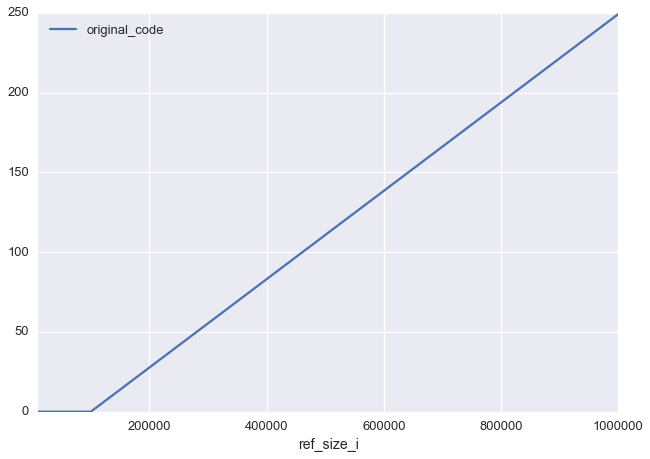

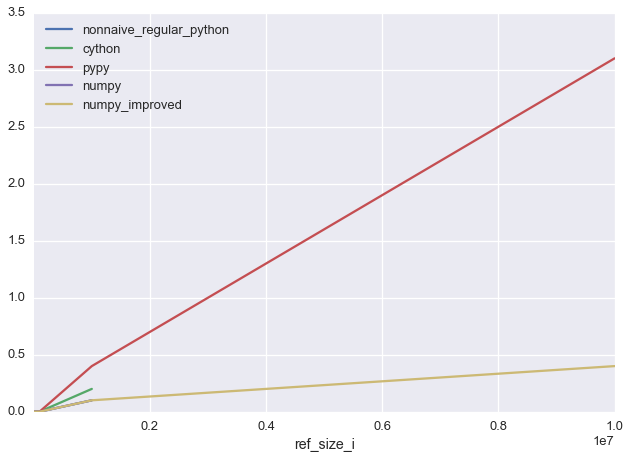

In [11]:
ax = ix_original_code_df[['ref_size_i','memory_used']].plot(x='ref_size_i',y='memory_used', label='original_code')
ax = ix_nonnaive_regular_python_df[['ref_size_i','memory_used']].plot(x='ref_size_i',y='memory_used', label='nonnaive_regular_python')
ax = ix_cython_df[['ref_size_i','memory_used']].plot(x='ref_size_i',y='memory_used', ax=ax, label='cython')
ax = ix_pypy_df[['ref_size_i','memory_used']].plot(x='ref_size_i',y='memory_used', ax=ax, label='pypy')
ax = ix_numpy_df[['ref_size_i','memory_used']].plot(x='ref_size_i',y='memory_used', ax=ax, label='numpy')
ax = ix_numpy_improved_df[['ref_size_i','memory_used']].plot(x='ref_size_i',y='memory_used', ax=ax, label='numpy_improved')

The memory usage for the indexing step using different sizes for the reference sequence. Note the different scales used for the two graphs. The original code shown above used extremely high amount of memory already for the 1M sequence. In fact it crashed due to memory overflow. The only code that finished indexing the 10M sequence within 1 hour was the numpy_improved code.

#### Conclusion:
The memory usage clearly varies and can after a quick test profiling run, extreme memory usage can often be avoided. The memory usage for the best performing code is still around 400MB for the reference 10Mb sequence. This could probably be made lower by more clever optimizations.

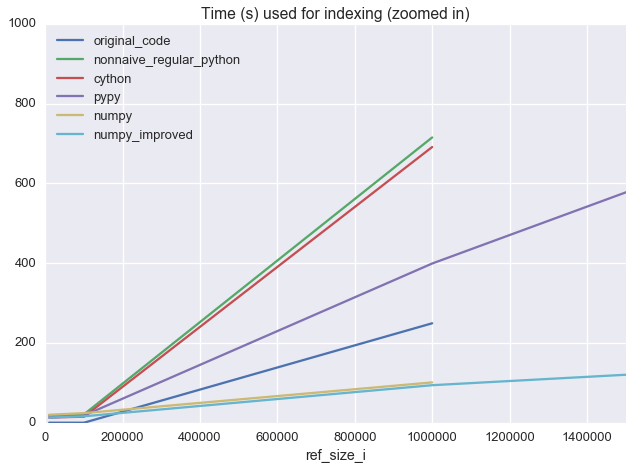

In [12]:
ax = ix_original_code_df[['ref_size_i','memory_used']].plot(x='ref_size_i',y='memory_used', label='original_code')
ax = ix_nonnaive_regular_python_df[['ref_size_i','runtime_s']].plot(x='ref_size_i',y='runtime_s', ax=ax, label='nonnaive_regular_python')
ax = ix_cython_df[['ref_size_i','runtime_s']].plot(x='ref_size_i',y='runtime_s', ax=ax, label='cython')
ax = ix_pypy_df[['ref_size_i','runtime_s']].plot(x='ref_size_i',y='runtime_s', ax=ax, label='pypy')
ax = ix_numpy_df[['ref_size_i','runtime_s']].plot(x='ref_size_i',y='runtime_s', ax=ax, label='numpy')
ax = ix_numpy_improved_df[['ref_size_i','runtime_s']].plot(x='ref_size_i',y='runtime_s', ax=ax, label='numpy_improved')
ax.set_xlim(0,1500000)
ax.set_ylim(0,1000)
ax.set_title('Time (s) used for indexing (zoomed in)')

Execution time in seconds for indexing using different sizes for input reference sequences. This graph is zoomed in to be able to more easily compare the code versions where the 10M reference sequence was not used. The time given for the original code for the 1M input sequence is the time until the program crashed due to memory overflow and should therefore not be compared to the other numbers.

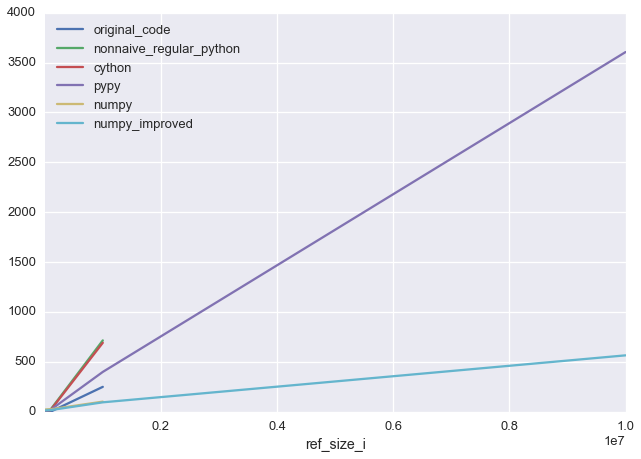

In [14]:
ax = ix_original_code_df[['ref_size_i','memory_used']].plot(x='ref_size_i',y='memory_used', label='original_code')
ax = ix_nonnaive_regular_python_df[['ref_size_i','runtime_s']].plot(x='ref_size_i',y='runtime_s', ax=ax, label='nonnaive_regular_python')
ax = ix_cython_df[['ref_size_i','runtime_s']].plot(x='ref_size_i',y='runtime_s', ax=ax, label='cython')
ax = ix_pypy_df[['ref_size_i','runtime_s']].plot(x='ref_size_i',y='runtime_s', ax=ax, label='pypy')
ax = ix_numpy_df[['ref_size_i','runtime_s']].plot(x='ref_size_i',y='runtime_s', ax=ax, label='numpy')
ax = ix_numpy_improved_df[['ref_size_i','runtime_s']].plot(x='ref_size_i',y='runtime_s', ax=ax, label='numpy_improved')
#ax.set_title()

NOTE: The pypy run for 10M did not finish within the time limit of 3600 seconds. Most programs were not tested with the 10M reference file due to the bad performance of the 1M file. 

#### Conclusion:
The execution time complexity for the `numpy_improved` looks quite linear which is very positive.

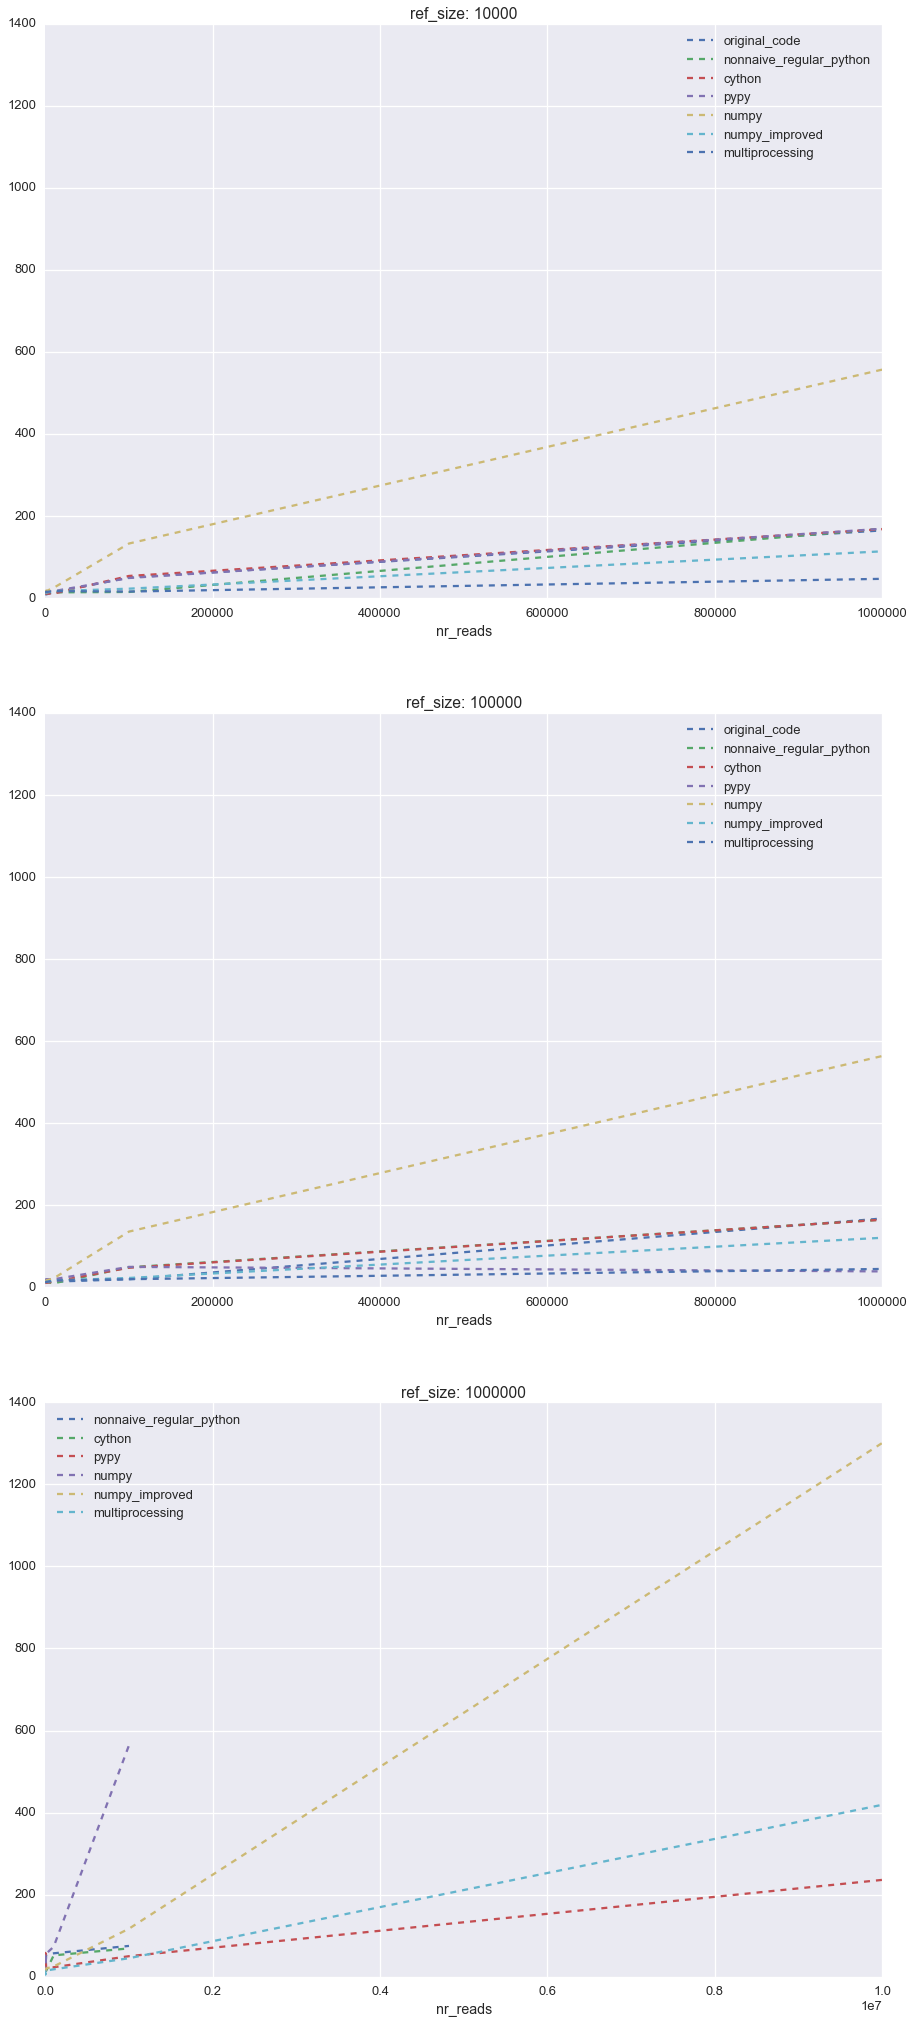

In [63]:
fig, axes = plt.subplots( figsize=(15.0, 35.0) , nrows=3, ncols=1, sharey=True)
ref_sizes = [10000, 100000, 1000000]
code_names = ['original_code', 'nonnaive_regular_python', 'cython', 'pypy', 'numpy', 'numpy_improved', 'multiprocessing']
code_dfs = [map_original_code_df, map_nonnaive_regular_python_df, map_cython_df, map_pypy_df, map_numpy_df, map_numpy_improved_df, map_multiprocessing_df]

for row, ax in enumerate(axes):
    ref_size = ref_sizes[row]
    ax.set_title("ref_size: {}".format(ref_size))
    
    for code_name, the_df in zip(code_names, code_dfs):
        filt_df = the_df[the_df['ref_size_i'] == ref_size]

        if len(filt_df) > 0:
            filt_df.sort_values('nr_reads')[['nr_reads','runtime_s']].plot(x='nr_reads', y='runtime_s', style='--', ax=ax, label=code_name)

The plots above show the execution time in seconds for increasing number of reads for fixed size of the reference sequence. It's impressive that `pypy` seems to be faster than `multiprocessing` even though it is only able to use one core while `multiprocessing` uses 16.

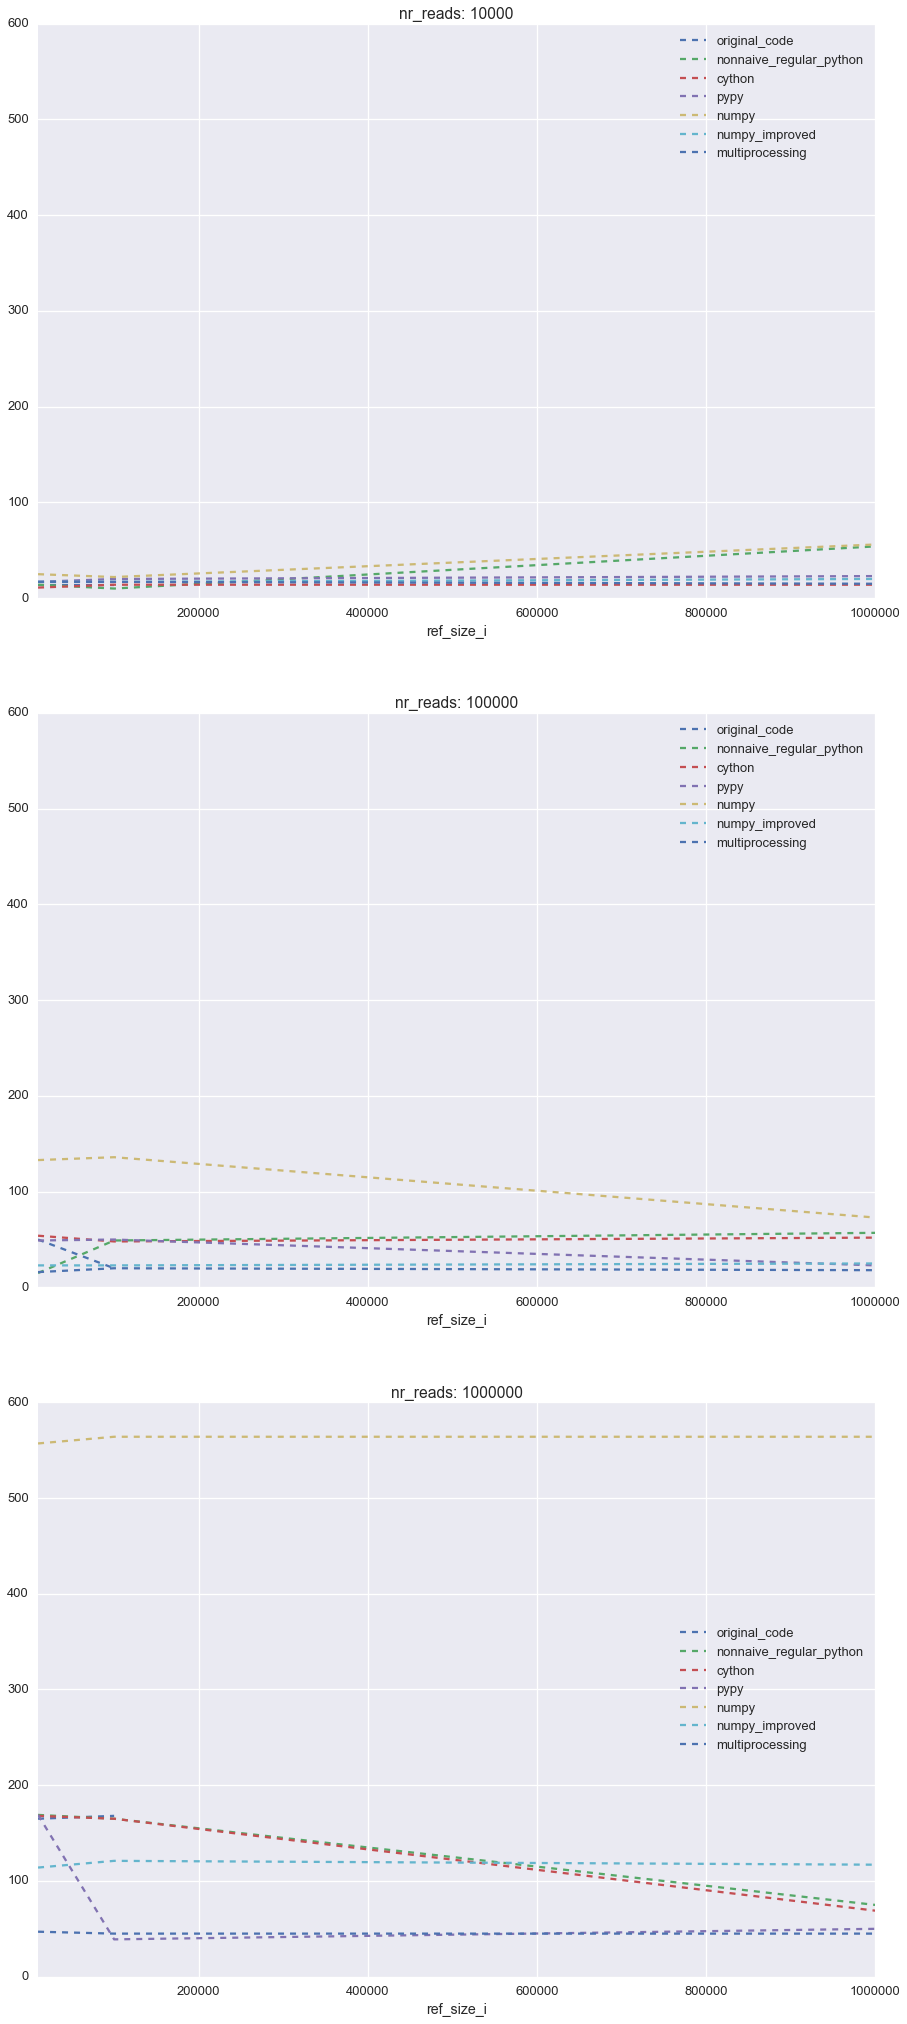

In [62]:
fig, axes = plt.subplots( figsize=(15.0, 35.0) , nrows=3, ncols=1, sharey=True)
#ref_sizes = [10000, 100000, 1000000]
nr_reads_alt = [10000, 100000,1000000]
code_names = ['original_code', 'nonnaive_regular_python', 'cython', 'pypy', 'numpy', 'numpy_improved', 'multiprocessing']
code_dfs = [map_original_code_df, map_nonnaive_regular_python_df, map_cython_df, map_pypy_df, map_numpy_df, map_numpy_improved_df, map_multiprocessing_df]

for row, ax in enumerate(axes):
    nr_reads = nr_reads_alt[row]
    ax.set_title("nr_reads: {}".format(nr_reads))
    
    for code_name, the_df in zip(code_names, code_dfs):
        filt_df = the_df[the_df['nr_reads'] == nr_reads]

        if len(filt_df) > 0:
            filt_df.sort_values('ref_size_i')[['ref_size_i','runtime_s']].plot(x='ref_size_i', y='runtime_s', style='--', ax=ax, label=code_name)

The plots above show how the execution time for the different versions of the program are affected by the reference size for fixed number of reads. It seems to be quite flat with respect to the size of the reference which is positive.

## Exercise 4
The point with this exercise was to experiment with parallel programming. I've already shown some of the results from multiprocessing but here is a quick comparison of the benefit of adding more cores for `multiprocessing` but also showing a mpi version of the code. 

In [64]:
par_mpi_df['runtime_s'] = par_mpi_df['runtime'].apply(time_to_seconds)
par_multiprocessing_df['runtime_s'] = par_multiprocessing_df['runtime'].apply(time_to_seconds)

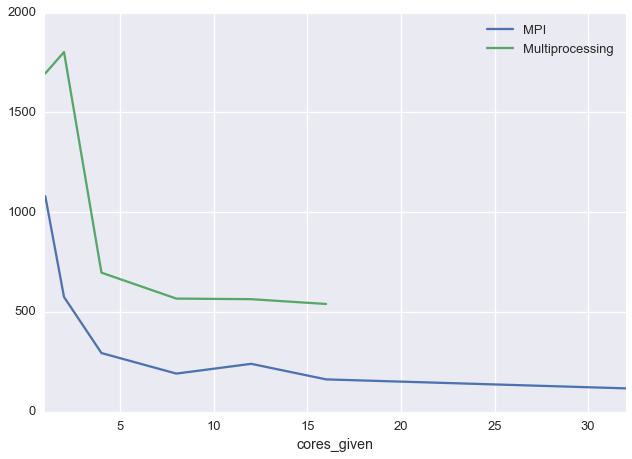

In [65]:
ax = par_mpi_df[['runtime_s','cores_given']].plot(x='cores_given', y='runtime_s', label='MPI')
ax = par_multiprocessing_df[['runtime_s','cores_given']].plot(x='cores_given', y='runtime_s', ax=ax, label='Multiprocessing')

The graph above shows the time taken for the program to map 10 million reads of length 25 against a 10 million long reference sequence for varying number of cores given. The benefit of additional cores decreases when the number of cores is higher. This is expected since new cores also increases the necessary communication between cores and does not decrease the I/O necessary from the root core.

The implementation of `multiprocessing` and `mpi` is slightly different. `Multiproccessing` uses a queue of reads which is streamed to a set of workers using individual processors. This should in theory reduce the memory footprint. The `MPI` implementation loads the complete input set into memory and distributes it to the other available processors. This seems to work well for the small number of reads we have here but for a larger set of reads it might be more clever to divide the reading and distribution into chunks of a predefined size.

In [ ]:
def mapper_main(args):
    ref_output = "{}.silly".format(args.reference)
    with open(ref_output, 'rb') as ref_fh:
        count_lookup, rank, burrows_wheeler, sa_index = pickle.load(ref_fh)

    total_length = len(sa_index)

    queue = Queue()
    NUMBER_OF_PROCESSES = cpu_count()
    workers = [Process(target=work, args=(queue, count_lookup, rank, total_length, sa_index)) 
            for i in range(NUMBER_OF_PROCESSES)]

    sys.stdout.write("read,start_position")
    for w in workers:
        w.start()

    serve_result = serve(queue, args)
    for w in workers:
        queue.put(None)
    [worker.join(10) for worker in workers]
    queue.close()
    sys.stdout.write('\n')

The main code for the multiprocessing mapper show above. Multiprocessing was quite easy to use once I tried, using a queue was quite intuitive. The biggest aha experience was when I had to redesign the writing to the output file since adding a newline from each individual process after each line resulted in one empty line for each process that has finished it's last read. As an alternative I could have returned the reads to the main process and done all the output writing from there, but this was easier to begin with.

In [ ]:
def mapper_main(args):
    ref_output = "{}.silly".format(args.reference)
    with open(ref_output, 'rb') as ref_fh:
        count_lookup, rank, burrows_wheeler, sa_index = pickle.load(ref_fh)

    total_length = len(sa_index)
    
    comm = MPI.COMM_WORLD
    NUMBER_OF_PROCESSES = comm.size
    mpi_rank = comm.Get_rank()

    if mpi_rank == 0:
        all_reads, tot_nr_reads = read_reads(args)
        m = tot_nr_reads/NUMBER_OF_PROCESSES
        all_reads = [all_reads[int(m*i):int(m*(i+1))] for i in range(NUMBER_OF_PROCESSES)]
    else:
        all_reads = None

    all_reads = comm.scatter(all_reads)

    result = []
    for queue_t in all_reads:
        if queue_t is None:
            break
        read_id, line = queue_t
        line = translate_to_binary(line.strip())
        s, e = backwards_search(line, count_lookup, rank, total_length)
        if s <= e:
            result.append("{},{}".format(read_id, sa_index[s]))

    result = comm.gather(result)

    if mpi_rank == 0:
        sys.stdout.write("read,start_position\n")
        for rank_result in result:
            if rank_result == []:
                continue
            sys.stdout.write('\n'.join(rank_result))
            sys.stdout.write('\n')

The MPI implementation shown above was slightly trickier to write since there were a lot of new terminology to understand. Especially how to use the methods comm.scatter and comm.gather and why to use those and not all of the other options available was tricky to figure out.

## Conclusion
This was real fun. Next time I will try to use this knowledge on something useful.